# Download a data file from the UCL server

We're using a small [example data set](http://data.cortexlab.net/singlePhase3/) recorded by [Nick Steinmetz](http://www.nicksteinmetz.com/) at UCL.

In [4]:
import urllib.request
file_url = 'http://data.cortexlab.net/singlePhase3/data/rawDataSample.bin'
file_name = "rawDataSample.bin"

urllib.request.urlretrieve(file_url, file_name)

('rawDataSample.bin', <http.client.HTTPMessage at 0x7f0aa19d82b0>)

# Use of the `HSDetection` class

## Important note

This is set up to run in the local directory structure.
To have a working HS2, run

``python setup.py build_ext --inplace``

in the project root directory.

In [5]:
import sys
sys.path.append('../')
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import NeuroPixel
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# raw data file (as downloaded above)
data_path = "rawDataSample.bin"

# detection parameters
to_localize = True
cutout_start = 6
cutout_end = 30
num_com_centers = 2
threshold = 20
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

In [7]:
Probe = NeuroPixel(data_path, neighbor_radius=120, masked_channels=[36, 75, 112, 151, 188, 227, 264, 303, 340, 379, 384])
H = HSDetection(Probe, to_localize, num_com_centers, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, decay_filtering=True, save_all=True)

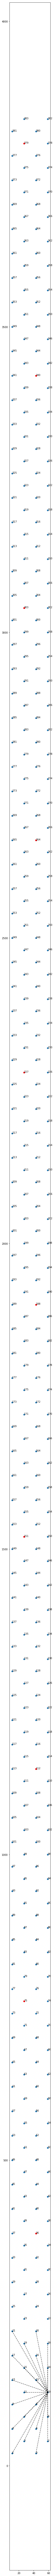

In [8]:
Probe.show()

In [9]:
H.DetectFromRaw()

# Sampling rate: 30000
# Localization On
# Masking Channels: [36, 75, 112, 151, 188, 227, 264, 303, 340, 379, 384]
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# Analysing 50000 frames; from 49958 to 100055
# Analysing 50000 frames; from 99958 to 150055
# Analysing 50000 frames; from 149958 to 200055
# Analysing 50000 frames; from 199958 to 250055
# Analysing 50000 frames; from 249958 to 300055
# Analysing 50000 frames; from 299958 to 350055
# Analysing 50000 frames; from 349958 to 400055
# Analysing 50000 frames; from 399958 to 450055
# Analysing 50000 frames; from 449958 to 500055
# Analysing 50000 frames; from 499958 to 550055
# Analysing 50000 frames; from 549958 to 600055
# Analysing 50000 frames; from 599958 to 650055
# Analysing 50000 frames; from 649958 to 700055
# An

In [10]:
H.LoadDetected()


Detected and read 137175 spikes.


Spike detected at channel:  358
Spike detected at frame:  217
41.984 3585.39
348  min  -49  at  18
349  min  -48  at  19
350  min  -45  at  19
351  min  -34  at  18
352  min  -29  at  5
353  min  -84  at  6
354  min  -46  at  5
355  min  -38  at  6
356  min  -82  at  6
357  min  -25  at  5
358  min  -125  at  6
359  min  -42  at  7
360  min  -65  at  8
361  min  -27  at  5
362  min  -15  at  0
363  min  -16  at  0
364  min  -17  at  25
365  min  -21  at  5
366  min  -22  at  24
367  min  -18  at  8
368  min  -18  at  25
369  min  -16  at  29


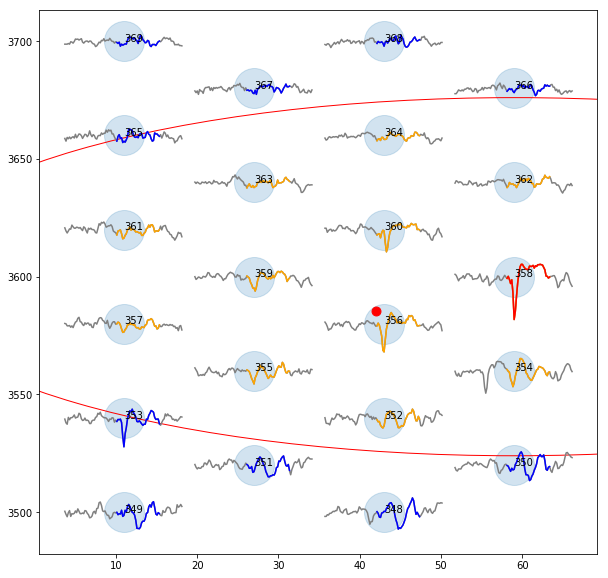

In [11]:
plt.figure(figsize=(10, 10))
H.PlotTracesChannels(15, window_size=100)

We have 137175 spikes, only showing 100000


(-100, 600)

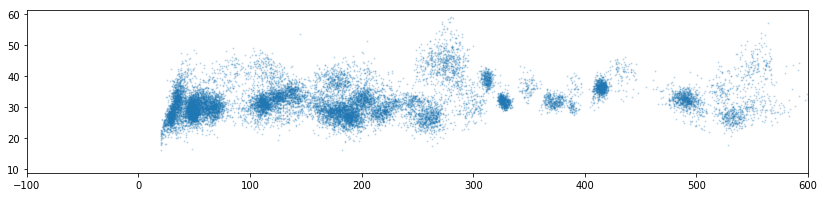

In [24]:
plt.figure(figsize=(14, 3))
ax = plt.subplot(111)
H.PlotAll(invert=True, s=1, alpha=0.2, ax=ax)
ax.set_xlim((-100,600))

# Use of the `HSClustering` class

In [18]:
from herdingspikes.hs2 import HSClustering

# Load from file
#C = Clustering(['results/ProcessedSpikes_mea1k.bin', 'results/ProcessedSpikes_mea1k.bin'], cutout_length=41)

# Or if the spikes are already in memory
# simply load from the Detection class
C = HSClustering(H)

In [20]:
%%time
# Compute features
C.ShapePCA(pca_ncomponents=2, pca_whiten=True);

Fitting PCA using 112613 spikes...
...projecting...
...done
CPU times: user 707 ms, sys: 765 ms, total: 1.47 s
Wall time: 550 ms


In [21]:
%%time
# Cluster all spikes

# This shows how a (potentially relatively small) subset of spikes 
# can be used to form clusters. All spikes are then assigned
# to these clusters in batches. This allows clustering of very large 
# recordings (also multiple files) without exhausting memory.

C.CombinedClustering(alpha=7, bandwidth=5.0, bin_seeding=False, n_jobs=-1, cluster_subset=100000)

Clustering...
Clustering using 100000 out of 112613 spikes...
number of seeds: 100000
seeds/job: 25001
using 4 cpus


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  3.0min finished


Number of estimated units: 3804
Predicting cluster labels for 112613 spikes...
CPU times: user 5.4 s, sys: 4.26 s, total: 9.66 s
Wall time: 3min 4s


We have 112613 spikes, only showing 100000


(30, 330)

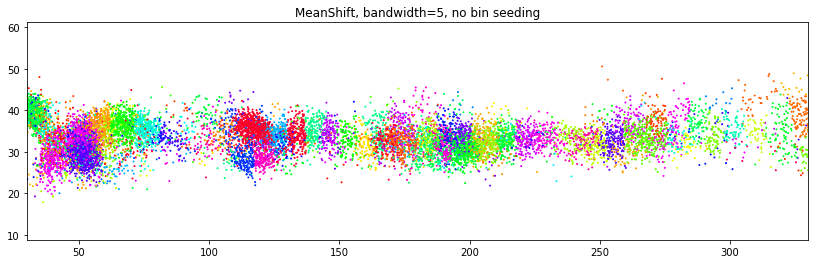

In [22]:
plt.figure(figsize=(14, 4))
ax = plt.subplot(111)
C.PlotAll(invert=True, s=1, ax=ax, max_show=100000, show_labels=False)
plt.title("MeanShift, bandwidth=5, no bin seeding");
ax.set_xlim((30,330))


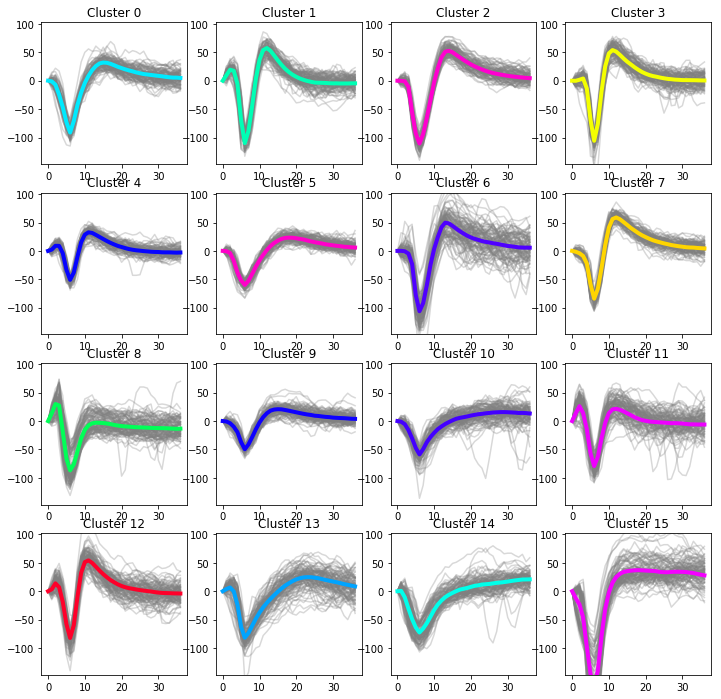

In [23]:
units = range(16)
C.PlotShapes(units)

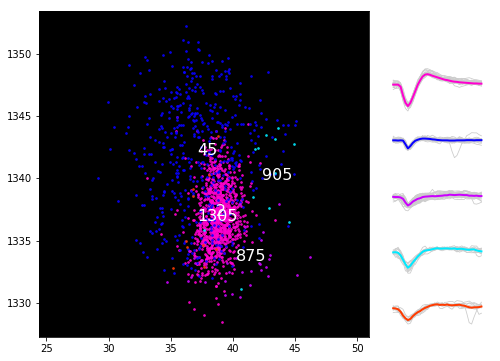

In [24]:
C.PlotNeighbourhood(2, radius=6, alpha=0.8);

In [26]:
# Save the results

C.SaveHDF5(file_name+"_sorted.hdf5")